In [37]:
import numpy as np
import pandas as pd
import gurobipy as grb
from gurobipy import GRB

import matplotlib.pyplot as plt

In [38]:
# 创建一个空的模型
model = grb.Model("Integrated_Energy_System")
model.setParam("OutputFlag", 0)
# 定义模型中的参数
# 时间步数，假设24小时
T = 24

# 设备功率和效率等参数（单位：MW 或者单位功率）
# 电解槽（EL）参数
PEL_max = 5  # 电解槽最大功率（MW）
ηEL = 0.75  # 电解槽效率
meh = 0.03954  # 氢气的热值（MWh/kg）
ΔPEL_up = 0.2  # 电解槽爬坡上限比例（MW）
ΔPEL_down = -0.2  # 电解槽爬坡下限（MW）
αEL = 25  # 电解槽运营和维护成本（¥/MWh）

# 氢燃料电池（HFC）参数
HHFC_max = 25  # 氢燃料电池最大功率（kg/h）
ηHFC = 0.95  # 氢燃料电池效率
ηHFC_e = 0.8  # 氢燃料电池电效率
ηHFC_h = 0.15  # 氢燃料电池热效率
ΔHHFC_up = 0.2  # 氢燃料电池功率爬坡上限比例（kg/h）
ΔHHFC_down = -0.2  # 氢燃料电池功率爬坡下限（kg/h）
αHFC = 18  # 氢燃料电池运营和维护成本（¥/MWh）

# 余热锅炉（WHB）参数
PWHB_max = 600  # 余热锅炉最大功率（MW）
ηWHB = 0.75  # 余热锅炉效率
αWHB = 65  # 余热锅炉运营和维护成本（¥/MWh）

αWT = 70  # 风力发电机运营和维护成本（¥/MWh）
αPV = 32  # 光伏发电运营和维护成本（¥/MWh）

# 燃气轮机（GT）参数
PGT_max = 580  # 燃气轮机最大功率（MW）
ηGT = 0.35  # 燃气轮机效率
ηloss = 0.1  # 能量损失率
ΔPGT_up = 0.2  # 燃气轮机爬坡上限比例（MW）
ΔPGT_down = -0.2  # 燃气轮机爬坡下限（MW）
αGT = 12.5  # 燃气轮机运营和维护成本（¥/MWh）

# 燃气锅炉（GB）参数
PGB_max = 1000  # 燃气锅炉最大功率（MW）
ηGB = 0.75  # 燃气锅炉效率
ΔPGB_up = 0.2  # 燃气锅炉爬坡上限比例（MW）
ΔPGB_down = -0.2  # 燃气锅炉爬坡下限（MW）
αGB = 85  # 燃气锅炉运营和维护成本（¥/MWh）

# 电储能（ES1）参数
Pmax_cha1 = 60  # 电储能充电最大功率（MW）
Pmax_dis1 = 60  # 电储能放电最大功率（MW）
Smin1 = 40  # 电储能最小容量（MWh）
Smax1 = 180  # 电储能最大容量（MWh）
ηcha_ES1 = 0.95  # 电储能充电效率
ηdis_ES1 = 0.95  # 电储能放电效率
α1 = 18  # 电储能的运行维护成本（¥/MWh）

# 热储能（ES2）参数
Pmax_cha2 = 60  # 热储能充电最大功率（MW）
Pmax_dis2 = 60  # 热储能放电最大功率（MW）
Smin2 = 40  # 热储能最小容量（MW）
Smax2 = 180  # 热储能最大容量（MW）
ηcha_ES2 = 0.95  # 热储能充电效率
ηdis_ES2 = 0.95  # 热储能放电效率
α2 = 16  # 热储能的运营维护成本（¥/MWh）

# 气储能（ES3）参数
Pmax_cha3 = 30  # 气储能充电最大功率（MW）
Pmax_dis3 = 30  # 气储能放电最大功率（MW）
Smin3 = 20  # 气储能最小容量（MW）
Smax3 = 90  # 气储能最大容量（MW）
ηcha_ES3 = 0.95  # 气储能充电效率
ηdis_ES3 = 0.95  # 气储能放电效率
α3 = 16  # 气储能的运营维护成本（¥/MWh）

# 氢储能（ES4）参数
Pmax_cha4 = 300  # 氢储能充电最大功率（kg/h）
Pmax_dis4 = 300  # 氢储能放电最大功率（kg/h）
Smin4 = 200  # 氢储能最小容量（kg）
Smax4 = 900  # 氢储能最大容量（kg）
ηcha_ES4 = 0.95  # 氢储能充电效率
ηdis_ES4 = 0.95  # 氢储能放电效率
α4 = 16  # 氢储能的运行维护成本（¥/kg）

# ========= 电价（¥/MWh），24 小时序列 =========
# 原始电价（¥/kWh）× 1000 → ¥/MWh
electricity_price = [
    343.8, 343.8, 343.8, 343.8, 343.8, 343.8, 343.8,   # 0:00–7:00
    680.0, 680.0, 680.0, 680.0,                        # 7:00–11:00
    811.0, 811.0, 811.0,                               # 11:00–14:00
    680.0, 680.0, 680.0,                               # 14:00–17:00
    811.0, 811.0, 811.0, 811.0, 811.0,                 # 17:00–22:00
    380.0, 380.0                                      # 22:00–24:00
]

# 氢气价格（¥/MWh）
hydrogen_price = 1500  # 氢气单价（¥/MWh）

# 天然气价格（¥/MWh）
natural_gas_price = 350  # 天然气单价（¥/MWh）

# 风电和光伏的弃电惩罚成本（¥/MWh）
wind_penalty = 200  # 风电弃电惩罚（¥/MWh）
solar_penalty = 200  # 光伏弃电惩罚（¥/MWh）

# 系统负荷（假设为占位）
electric_load = [15, 25, 26, 28, 28, 32, 35, 41, 43, 49, 55, 68, 66, 56, 43, 42, 47, 51, 53, 54, 50, 39, 30, 27]
thermal_load = [45, 24, 38, 48, 51, 58, 43, 58, 68, 83, 80, 84, 70, 68, 65, 62, 65, 88, 50, 48, 45, 55, 63, 50]
hydrogen_load = [80, 66, 60, 50, 50, 55, 55, 100, 152, 136, 80, 70, 70, 70, 90, 90, 80, 70, 70, 70, 70, 70, 70, 70]
gas_load =  [10, 13, 12, 11, 14, 15, 14, 15, 13, 10, 12, 15, 15, 15, 14, 13, 11, 11, 12, 12, 13, 10, 9, 8]


In [ ]:
# =========================
# 0) 时间步长（默认 1 小时）
# =========================
dt = 1.0  # hour

# =========================
# 1) 可再生出力上限
# =========================
WT_avail =[20, 33, 36, 46, 47, 43, 40, 50, 38, 34, 48, 31, 38, 29, 11, 8, 32, 47, 33, 42, 52, 50, 59, 42.5]
PV_avail = [0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 30, 40, 45, 46, 43, 33, 21, 8, 0, 0, 0, 0, 0, 0]  # 每小时光伏可用出力上限（MW）

# =========================
# 2) 统一“比例爬坡”参数
# =========================
ramp_GT  = abs(ΔPGT_up)
ramp_GB  = abs(ΔPGB_up)
ramp_EL  = abs(ΔPEL_up)
ramp_HFC = abs(ΔHHFC_up)

# =========================
# 3) 变量定义
# =========================
# ---- 外购（无上限，仅非负）----
Pbuy_e = model.addVars(T, lb=0.0, name="Pbuy_e")   # 外购电（MW）
Pbuy_g = model.addVars(T, lb=0.0, name="Pbuy_g")   # 外购天然气（MW）
Pbuy_H = model.addVars(T, lb=0.0, name="Pbuy_H")   # 外购氢（kg/h）  

# ---- 可再生与弃电 ----
PWT     = model.addVars(T, lb=0.0, name="PWT")      # 实际风电利用（MW）
PWT_cut = model.addVars(T, lb=0.0, name="PWT_cut")  # 风电弃电（MW）
PPV     = model.addVars(T, lb=0.0, name="PPV")      # 实际光伏利用（MW）
PPV_cut = model.addVars(T, lb=0.0, name="PPV_cut")  # 光伏弃电（MW）

# ---- GT：电功率/气输入/热输出 ----
PGT_e = model.addVars(T, lb=0.0, ub=PGT_max, name="PGT_e")  # GT发电（MW）
PGT_g = model.addVars(T, lb=0.0, name="PGT_g")              # GT耗气（MW）
PGT_h = model.addVars(T, lb=0.0, name="PGT_h")              # GT产热（MW）

# ---- GB：热功率/气输入 ----
PGB_h = model.addVars(T, lb=0.0, ub=PGB_max, name="PGB_h")  # GB产热（MW）
PGB_g = model.addVars(T, lb=0.0, name="PGB_g")              # GB耗气（MW）

# ---- WHB：回收热 ----
PWHB_h = model.addVars(T, lb=0.0, ub=PWHB_max, name="PWHB_h")  # WHB回收热（MW）

# ---- EL：耗电与产氢 ----
PEL_e = model.addVars(T, lb=0.0, ub=PEL_max, name="PEL_e")  # EL耗电（MW）
HEL   = model.addVars(T, lb=0.0, name="HEL")                # EL产氢（kg/h）

# ---- HFC：耗氢与电/热输出 ----
HHFC    = model.addVars(T, lb=0.0, ub=HHFC_max, name="HHFC")      # HFC耗氢（kg/h）
PHFC_tot = model.addVars(T, lb=0.0, name="PHFC_tot")              # HFC总能量输出（MW）
PHFC_e   = model.addVars(T, lb=0.0, name="PHFC_e")                # HFC电输出（MW）
PHFC_h   = model.addVars(T, lb=0.0, name="PHFC_h")                # HFC热输出（MW）

# ---- 储能：ES1 电（MWh/MW）----
Pcha1 = model.addVars(T, lb=0.0, ub=Pmax_cha1, name="Pcha_ES1")   # 充电功率（MW）
Pdis1 = model.addVars(T, lb=0.0, ub=Pmax_dis1, name="Pdis_ES1")   # 放电功率（MW）
bcha1 = model.addVars(T, vtype=GRB.BINARY, name="bcha_ES1")       # 充电状态
bdis1 = model.addVars(T, vtype=GRB.BINARY, name="bdis_ES1")       # 放电状态

# ---- 储能：ES2 热（MWh/MW）----
Pcha2 = model.addVars(T, lb=0.0, ub=Pmax_cha2, name="Pcha_ES2")
Pdis2 = model.addVars(T, lb=0.0, ub=Pmax_dis2, name="Pdis_ES2")
bcha2 = model.addVars(T, vtype=GRB.BINARY, name="bcha_ES2")
bdis2 = model.addVars(T, vtype=GRB.BINARY, name="bdis_ES2")

# ---- 储能：ES3 气（MWh/MW）----
Pcha3 = model.addVars(T, lb=0.0, ub=Pmax_cha3, name="Pcha_ES3")
Pdis3 = model.addVars(T, lb=0.0, ub=Pmax_dis3, name="Pdis_ES3")
bcha3 = model.addVars(T, vtype=GRB.BINARY, name="bcha_ES3")
bdis3 = model.addVars(T, vtype=GRB.BINARY, name="bdis_ES3")

# ---- 储能：ES4 氢（kg / kg/h）----
Pcha4 = model.addVars(T, lb=0.0, ub=Pmax_cha4, name="Pcha_ES4")   # 充氢（kg/h）
Pdis4 = model.addVars(T, lb=0.0, ub=Pmax_dis4, name="Pdis_ES4")   # 放氢（kg/h）
bcha4 = model.addVars(T, vtype=GRB.BINARY, name="bcha_ES4")
bdis4 = model.addVars(T, vtype=GRB.BINARY, name="bdis_ES4")

# ---- SOC变量下界必须允许SOC[0]=0（做法A+论文S(1)=0需要）----
SOC1  = model.addVars(T, lb=0.0, ub=GRB.INFINITY, name="SOC_ES1")  # 电储能能量（MWh）
SOC2  = model.addVars(T, lb=0.0, ub=GRB.INFINITY, name="SOC_ES2")  # 热储能能量（MWh）
SOC3  = model.addVars(T, lb=0.0, ub=GRB.INFINITY, name="SOC_ES3")  # 气储能能量（MWh）
SOC4  = model.addVars(T, lb=0.0, ub=GRB.INFINITY, name="SOC_ES4")  # 氢库存（kg）

# =========================
# 4) 设备机理约束（按设备顺序：WT → PV → GT → WHB → GB → EL → HFC）
# =========================
for t in range(T):

    # -------- WT：可用出力与弃电 --------
    model.addConstr(PWT[t] + PWT_cut[t] == WT_avail[t],name=f"WT_avail_{t}")  # 风电利用+弃电=可用出力

    # -------- PV：可用出力与弃电 --------
    model.addConstr(PPV[t] + PPV_cut[t] == PV_avail[t],name=f"PV_avail_{t}")  # 光伏利用+弃电=可用出力

    # -------- GT：气->电、并联产热 --------
    model.addConstr(PGT_e[t] == ηGT * PGT_g[t],name=f"GT_g2e_{t}")  # GT发电与耗气关系：PGT_e = ηGT * PGT_g
    model.addConstr(PGT_h[t] == PGT_e[t] * (1.0 - ηGT - ηloss) / ηGT,name=f"GT_e2h_{t}")  # GT发电对应产热：PGT_h = PGT_e*(1-ηGT-ηloss)/ηGT

    # -------- WHB：回收GT余热 --------
    model.addConstr(PWHB_h[t] == ηWHB * PGT_h[t],name=f"WHB_recover_{t}")  # 余热锅炉回收热：PWHB_h = ηWHB * PGT_h

    # -------- GB：气->热 --------
    model.addConstr(PGB_h[t] == ηGB * PGB_g[t],name=f"GB_g2h_{t}")  # 燃气锅炉产热与耗气关系：PGB_h = ηGB * PGB_g

    # -------- EL：电->氢 --------
    model.addConstr(HEL[t] == ηEL * PEL_e[t] / meh,name=f"EL_e2H_{t}")  # 电解槽产氢：HEL = ηEL * PEL_e / meh

    # -------- HFC：氢->功率，并拆分电/热 --------
    model.addConstr(PHFC_tot[t] == ηHFC * HHFC[t] * meh, name=f"HFC_H2P_{t}")  # 氢燃料电池总输出：PHFC_tot = ηHFC * HHFC * meh
    model.addConstr(PHFC_e[t] == ηHFC_e * PHFC_tot[t],name=f"HFC_P2e_{t}")  # HFC电输出：PHFC_e = ηHFC_e * PHFC_tot
    model.addConstr(PHFC_h[t] == ηHFC_h * PHFC_tot[t],name=f"HFC_P2h_{t}")  # HFC热输出：PHFC_h = ηHFC_h * PHFC_tot


# =========================
# 5) 爬坡约束（按设备顺序：GT → GB → EL → HFC；比例爬坡：±ramp * 额定值）
# =========================
for t in range(T - 1):
    # -------- GT：发电爬坡 --------
    model.addConstr(PGT_e[t+1] - PGT_e[t] <= ramp_GT * PGT_max,name=f"ramp_GT_up_{t}")  # GT上爬坡
    model.addConstr(PGT_e[t+1] - PGT_e[t] >= -ramp_GT * PGT_max,name=f"ramp_GT_dn_{t}")  # GT下爬坡
    # -------- GB：产热爬坡 --------
    model.addConstr(PGB_h[t+1] - PGB_h[t] <= ramp_GB * PGB_max,name=f"ramp_GB_up_{t}")  # GB上爬坡
    model.addConstr(PGB_h[t+1] - PGB_h[t] >= -ramp_GB * PGB_max,name=f"ramp_GB_dn_{t}")  # GB下爬坡
    # -------- EL：耗电爬坡 --------
    model.addConstr(PEL_e[t+1] - PEL_e[t] <= ramp_EL * PEL_max,name=f"ramp_EL_up_{t}")  # EL上爬坡
    model.addConstr(PEL_e[t+1] - PEL_e[t] >= -ramp_EL * PEL_max,name=f"ramp_EL_dn_{t}")  # EL下爬
    # -------- HFC：耗氢爬坡（对HHFC）--------
    model.addConstr(HHFC[t+1] - HHFC[t] <= ramp_HFC * HHFC_max, name=f"ramp_HFC_up_{t}")  # HFC上爬坡
    model.addConstr(HHFC[t+1] - HHFC[t] >= -ramp_HFC * HHFC_max,name=f"ramp_HFC_dn_{t}")  # HFC下爬坡

from gurobipy import GRB
import math

# =========================
# 6) 储能约束（严格按论文 Eq.(19)-(20)）
# - 0 ≤ Pcha_ES,n(t) ≤ Bcha_ES,n(t) * 0.3 * Pmax_n
# - Pcha_ES,n(1) ≥ 0.2 * Pmax_n
# - 0 ≤ Pdis_ES,n(t) ≤ Bdis_ES,n(t) * 0.3 * Pmax_n
# - S_n(t+1) = (1-μ)S_n(t) + ηcha*Pcha(t) - Pdis(t)/ηdis   （用标准离散形式，功率作用于下一时刻SOC）
# - 0.2*Pmax_n ≤ S_n(t) ≤ 0.9*Pmax_n   （从第2个时段开始施加，避免与S_n(1)=0冲突）
# - S_n(1) = 0
# - S_n(1) = S_n(T) + ΔS_n
# =========================

# ---- 自放电率（论文：电储能0.001，其它0）----
mu_ES1 = 0.001
mu_ES2 = 0.0
mu_ES3 = 0.0
mu_ES4 = 0.0

# 论文约束：Smax = 0.9*Pmax, Smin = 0.2*Pmax
Pmax2_rated = Smax2 / 0.9   # 热储能额定容量
Pmax3_rated = Smax3 / 0.9   # 气储能额定容量
Pmax4_rated = Smax4 / 0.9   # 氢储能额定容量（kg）

# ---- 电储能容量衰减（论文 Eq.(19)）----
a_deg = 200.0
b_deg = 4.168e-4
c_deg = 1.9984e-7
d_deg = 0.0332

Pmax1_eff = [0.0] * T
for t in range(T):
    tau = float(t + 1)  # 论文t为运行时间指标；避免sqrt(0)
    Pmax1_eff[t] = a_deg + b_deg * tau - c_deg * (tau ** 2) - d_deg * math.sqrt(tau)

# ---- ΔS_n（首末SOC不完全相等）----
dSOC1 = model.addVar(lb=-GRB.INFINITY, name="dSOC1")  # 电储能ΔS
dSOC2 = model.addVar(lb=-GRB.INFINITY, name="dSOC2")  # 热储能ΔS
dSOC3 = model.addVar(lb=-GRB.INFINITY, name="dSOC3")  # 气储能ΔS
dSOC4 = model.addVar(lb=-GRB.INFINITY, name="dSOC4")  # 氢储能ΔS

# =========================
# 6.1 互斥约束 + 充放功率上限（0.3*Pmax）
# =========================
for t in range(T):
    # --- 互斥：Bcha + Bdis <= 1 ---
    model.addConstr(bcha1[t] + bdis1[t] <= 1, name=f"ES1_mutex_{t}")  # 电储能互斥
    model.addConstr(bcha2[t] + bdis2[t] <= 1, name=f"ES2_mutex_{t}")  # 热储能互斥
    model.addConstr(bcha3[t] + bdis3[t] <= 1, name=f"ES3_mutex_{t}")  # 气储能互斥
    model.addConstr(bcha4[t] + bdis4[t] <= 1, name=f"ES4_mutex_{t}")  # 氢储能互斥

    # --- 充电功率上限：0 ≤ Pcha ≤ Bcha * 0.3 * Pmax ---
    model.addConstr(Pcha1[t] <= bcha1[t] * 0.3 * Pmax1_eff[t], name=f"ES1_cha_cap_{t}")  # 电储能充电功率
    model.addConstr(Pcha2[t] <= bcha2[t] * 0.3 * Pmax2_rated,  name=f"ES2_cha_cap_{t}")  # 热储能充电功率
    model.addConstr(Pcha3[t] <= bcha3[t] * 0.3 * Pmax3_rated,  name=f"ES3_cha_cap_{t}")  # 气储能充电功率
    model.addConstr(Pcha4[t] <= bcha4[t] * 0.3 * Pmax4_rated,  name=f"ES4_cha_cap_{t}")  # 氢储能充氢功率(kg/h)

    # --- 放电功率上限：0 ≤ Pdis ≤ Bdis * 0.3 * Pmax ---
    model.addConstr(Pdis1[t] <= bdis1[t] * 0.3 * Pmax1_eff[t], name=f"ES1_dis_cap_{t}")  # 电储能放电功率
    model.addConstr(Pdis2[t] <= bdis2[t] * 0.3 * Pmax2_rated,  name=f"ES2_dis_cap_{t}")  # 热储能放电功率
    model.addConstr(Pdis3[t] <= bdis3[t] * 0.3 * Pmax3_rated,  name=f"ES3_dis_cap_{t}")  # 气储能放电功率
    model.addConstr(Pdis4[t] <= bdis4[t] * 0.3 * Pmax4_rated,  name=f"ES4_dis_cap_{t}")  # 氢储能放氢功率(kg/h)

# --- 首时段最低充能功率要求：Pcha(1) ≥ 0.2*Pmax（论文 Eq.(19)）---
# 注：论文用t=1..T；你代码用t=0..T-1，因此这里对应 t=0
model.addConstr(Pcha1[0] >= 0.2 * Pmax1_eff[0], name="ES1_min_charge_t0")  # 电储能首时段最低充电
model.addConstr(Pcha2[0] >= 0.2 * Pmax2_rated,  name="ES2_min_charge_t0")  # 热储能首时段最低充能
model.addConstr(Pcha3[0] >= 0.2 * Pmax3_rated,  name="ES3_min_charge_t0")  # 气储能首时段最低充能
model.addConstr(Pcha4[0] >= 0.2 * Pmax4_rated,  name="ES4_min_charge_t0")  # 氢储能首时段最低充能(kg/h)

# =========================
# 6.2 SOC 初值（S_n(1)=0） + SOC 动态
# 使用标准离散：SOC[t+1] = (1-μ)SOC[t] + ηcha*Pcha[t] - Pdis[t]/ηdis
# =========================
# --- 初值：SOC(1)=0 对应 SOC[0]=0 ---
model.addConstr(SOC1[0] == 0.0, name="ES1_init_SOC0")  # 电储能初值
model.addConstr(SOC2[0] == 0.0, name="ES2_init_SOC0")  # 热储能初值
model.addConstr(SOC3[0] == 0.0, name="ES3_init_SOC0")  # 气储能初值
model.addConstr(SOC4[0] == 0.0, name="ES4_init_SOC0")  # 氢储能初值

for t in range(T - 1):
    # 电储能SOC动态
    model.addConstr(SOC1[t+1] == (1.0 - mu_ES1) * SOC1[t] + (ηcha_ES1 * Pcha1[t] - Pdis1[t] / ηdis_ES1) * dt,
                    name=f"ES1_SOC_dyn_{t}")  # SOC1更新

    # 热储能SOC动态
    model.addConstr(SOC2[t+1] == (1.0 - mu_ES2) * SOC2[t] + (ηcha_ES2 * Pcha2[t] - Pdis2[t] / ηdis_ES2) * dt,
                    name=f"ES2_SOC_dyn_{t}")  # SOC2更新

    # 气储能SOC动态
    model.addConstr(SOC3[t+1] == (1.0 - mu_ES3) * SOC3[t] + (ηcha_ES3 * Pcha3[t] - Pdis3[t] / ηdis_ES3) * dt,
                    name=f"ES3_SOC_dyn_{t}")  # SOC3更新

    # 氢储能SOC动态（kg）
    model.addConstr(SOC4[t+1] == (1.0 - mu_ES4) * SOC4[t] + (ηcha_ES4 * Pcha4[t] - Pdis4[t] / ηdis_ES4) * dt,
                    name=f"ES4_SOC_dyn_{t}")  # SOC4更新

# =========================
# 6.3 SOC 范围：0.2*Pmax ≤ SOC(t) ≤ 0.9*Pmax
# 论文里同时给了 S_n(1)=0，因此SOC范围从“第2个时段”开始施加
# 索引：从 t=1 开始施加（跳过 t=0）
# =========================
for t in range(1, T):
    # 电储能：使用衰减后的Pmax1_eff[t]
    model.addConstr(SOC1[t] >= 0.2 * Pmax1_eff[t], name=f"ES1_SOC_min_{t}")  # 电储能SOC下限
    model.addConstr(SOC1[t] <= 0.9 * Pmax1_eff[t], name=f"ES1_SOC_max_{t}")  # 电储能SOC上限

    # 热/气/氢：使用额定容量常数
    model.addConstr(SOC2[t] >= 0.2 * Pmax2_rated, name=f"ES2_SOC_min_{t}")   # 热储能SOC下限
    model.addConstr(SOC2[t] <= 0.9 * Pmax2_rated, name=f"ES2_SOC_max_{t}")   # 热储能SOC上限

    model.addConstr(SOC3[t] >= 0.2 * Pmax3_rated, name=f"ES3_SOC_min_{t}")   # 气储能SOC下限
    model.addConstr(SOC3[t] <= 0.9 * Pmax3_rated, name=f"ES3_SOC_max_{t}")   # 气储能SOC上限

    model.addConstr(SOC4[t] >= 0.2 * Pmax4_rated, name=f"ES4_SOC_min_{t}")   # 氢储能SOC下限
    model.addConstr(SOC4[t] <= 0.9 * Pmax4_rated, name=f"ES4_SOC_max_{t}")   # 氢储能SOC上限

# =========================
# 6.4 首末SOC关系：S_n(1) = S_n(T) + ΔS_n
# 索引：SOC[0] = SOC[T-1] + dSOC
# =========================
model.addConstr(SOC1[0] == SOC1[T-1] + dSOC1, name="ES1_cycle_with_dSOC")  # 电储能首末关系
model.addConstr(SOC2[0] == SOC2[T-1] + dSOC2, name="ES2_cycle_with_dSOC")  # 热储能首末关系
model.addConstr(SOC3[0] == SOC3[T-1] + dSOC3, name="ES3_cycle_with_dSOC")  # 气储能首末关系
model.addConstr(SOC4[0] == SOC4[T-1] + dSOC4, name="ES4_cycle_with_dSOC")  # 氢储能首末关系

# =========================
# 7) 四能量平衡约束（电/热/气/氢）
# =========================
for t in range(T):
    # --- 电平衡：外购电 + GT电 + HFC电 + 电储能放电 + WT + PV = 电负荷 + EL耗电 + 电储能充电 ---
    model.addConstr(Pbuy_e[t] + PGT_e[t] + PHFC_e[t] + Pdis1[t] + PWT[t] + PPV[t]== electric_load[t] + PEL_e[t] + Pcha1[t],
                    name=f"Balance_Elec_{t}")  # 电功率平衡

    # --- 热平衡：WHB热 + HFC热 + GB热 + 热储能放热 = 热负荷 + 热储能充热 ---
    model.addConstr(PWHB_h[t] + PHFC_h[t] + PGB_h[t] + Pdis2[t]== thermal_load[t] + Pcha2[t],name=f"Balance_Heat_{t}")  # 热功率平衡

    # --- 气平衡：外购气 + 气储能放气 = 气负荷 + 气储能充气 + GT耗气 + GB耗气 ---
    model.addConstr(Pbuy_g[t] + Pdis3[t]== gas_load[t] + Pcha3[t] + PGT_g[t] + PGB_g[t],name=f"Balance_Gas_{t}")  # 天然气功率平衡

    # --- 氢平衡（质量流量口径）：外购氢 + EL产氢 + 氢储能放氢 = 氢负荷 + 氢储能充氢 + HFC耗氢 ---
    model.addConstr(Pbuy_H[t] + HEL[t] + Pdis4[t]== hydrogen_load[t] + Pcha4[t] + HHFC[t],name=f"Balance_H2_{t}")  # 氢平衡（kg/h）
# 约束部分结束


In [40]:
# =========================
# 目标函数：最小化总运行成本
# 成本构成：
# 1) 外购能源成本（电/气/氢）
# 2) 设备运维成本（GT/GB/WHB/EL/HFC/WT/PV）
# 3) 储能运维成本（按充放电吞吐计）
# 4) 弃风弃光惩罚
# =========================
total_cost = grb.LinExpr()

for t in range(T):
    # ---- 1) 外购能源成本 ----
    # 外购电：¥/MWh * MW * h
    total_cost += electricity_price[t] * Pbuy_e[t] * dt
    # 外购气：¥/MWh * MW * h
    total_cost += natural_gas_price * Pbuy_g[t] * dt
    # 外购氢：hydrogen_price(¥/MWh) * (kg/h * MWh/kg) * h
    total_cost += hydrogen_price * (Pbuy_H[t] * meh) * dt
    
    # ---- 2) 设备运维成本（按功率/出力计）----
    # GT：按发电功率计（MW）
    total_cost += αGT * PGT_e[t] * dt
    # GB：按产热功率计（MW）
    total_cost += αGB * PGB_h[t] * dt
    # WHB：按回收热功率计（MW）
    total_cost += αWHB * PWHB_h[t] * dt
    # EL：按耗电功率计（MW）
    total_cost += αEL * PEL_e[t] * dt
    # HFC：按总输出功率计（MW）
    total_cost += αHFC * PHFC_tot[t] * dt
    # WT/PV：按实际利用出力计（MW）
    total_cost += αWT * PWT[t] * dt
    total_cost += αPV * PPV[t] * dt

    # ---- 3) 储能运维成本（按充放电吞吐计）----
    # 电/热/气储能：α(¥/MWh) * (Pcha+Pdis)(MW) * h
    total_cost += α1 * (Pcha1[t] + Pdis1[t]) * dt
    total_cost += α2 * (Pcha2[t] + Pdis2[t]) * dt
    total_cost += α3 * (Pcha3[t] + Pdis3[t]) * dt
    # 氢储能：α4(¥/kg) * (Pcha+Pdis)(kg/h) * h
    total_cost += α4 * (Pcha4[t] + Pdis4[t]) * dt

    # ---- 4) 弃电惩罚（¥/MWh * MW * h）----
    total_cost += wind_penalty * PWT_cut[t] * dt
    total_cost += solar_penalty * PPV_cut[t] * dt

# 设置目标：最小化总成本
model.setObjective(total_cost, GRB.MINIMIZE)


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

model.optimize()

if model.status != GRB.OPTIMAL:
    print("未得到最优解，status =", model.status)
else:
    print("最小总成本 ObjVal =", model.ObjVal)

    def vlist(vdict, T):
        """把 addVars 返回的 tupledict 取成长度T的list"""
        return [vdict[t].X for t in range(T)]

    # ========= 提取电侧 =========
    res = pd.DataFrame({
        "t": list(range(T)),
        "E_Load": electric_load,

        "E_Buy": vlist(Pbuy_e, T),
        "WT": vlist(PWT, T),
        "PV": vlist(PPV, T),
        "GT_e": vlist(PGT_e, T),
        "HFC_e": vlist(PHFC_e, T),
        "ES1_dis": vlist(Pdis1, T),

        "EL_e": vlist(PEL_e, T),
        "ES1_cha": vlist(Pcha1, T),
        "WT_cut": vlist(PWT_cut, T),
        "PV_cut": vlist(PPV_cut, T),
    })

    # ========= 提取热侧 =========
    res["H_Load"]   = thermal_load
    res["WHB_h"]    = vlist(PWHB_h, T)
    res["GB_h"]     = vlist(PGB_h, T)
    res["HFC_h"]    = vlist(PHFC_h, T)
    res["ES2_dis"]  = vlist(Pdis2, T)
    res["ES2_cha"]  = vlist(Pcha2, T)

    # ========= 提取气侧 =========
    res["G_Load"]  = gas_load
    res["G_Buy"]   = vlist(Pbuy_g, T)
    res["ES3_dis"] = vlist(Pdis3, T)
    res["ES3_cha"] = vlist(Pcha3, T)
    res["GT_g"]    = vlist(PGT_g, T)
    res["GB_g"]    = vlist(PGB_g, T)

    # ========= 提取氢侧 =========
    res["H2_Load"]  = hydrogen_load
    res["H2_Buy"]   = vlist(Pbuy_H, T)     # kg/h
    res["EL_H2"]    = vlist(HEL, T)        # kg/h
    res["ES4_dis"]  = vlist(Pdis4, T)      # kg/h
    res["ES4_cha"]  = vlist(Pcha4, T)      # kg/h
    res["HFC_H2"]   = vlist(HHFC, T)       # kg/h

    # ========= SOC（可选，用于检查）=========
    res["SOC1"] = vlist(SOC1, T)
    res["SOC2"] = vlist(SOC2, T)
    res["SOC3"] = vlist(SOC3, T)
    res["SOC4"] = vlist(SOC4, T)

    # 导出（可选）
    res.to_csv("dispatch_24h.csv", index=False, encoding="utf-8-sig")
    print("已导出 dispatch_24h.csv")


最小总成本 ObjVal = 995809.2166713328
已导出 dispatch_24h.csv


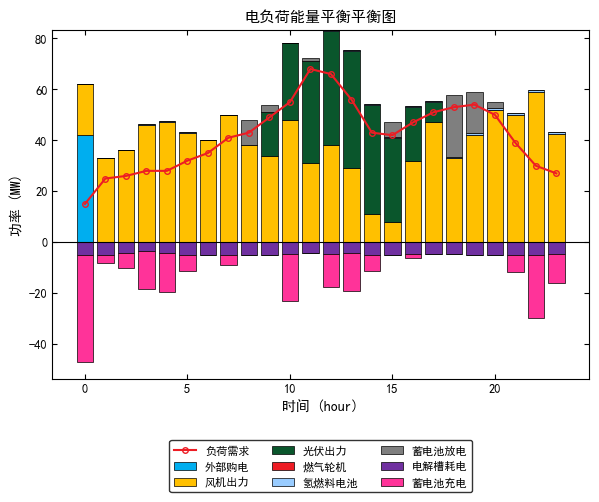

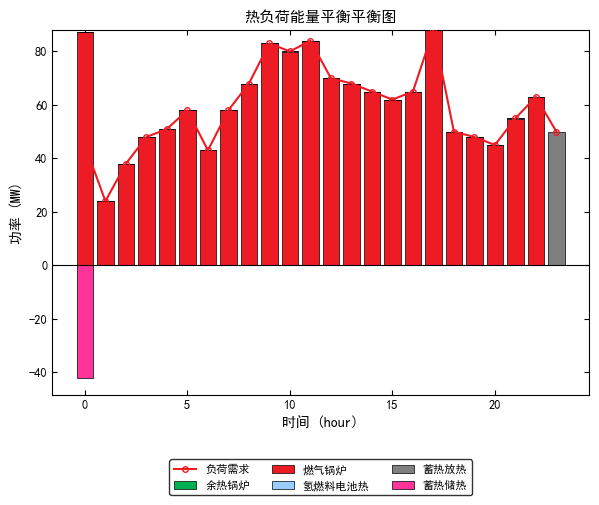

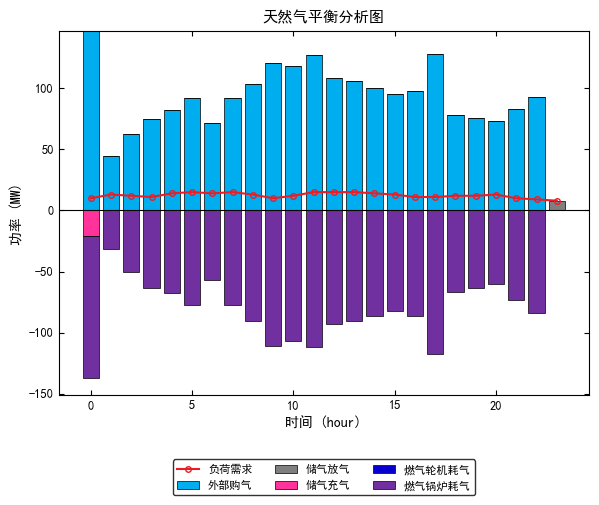

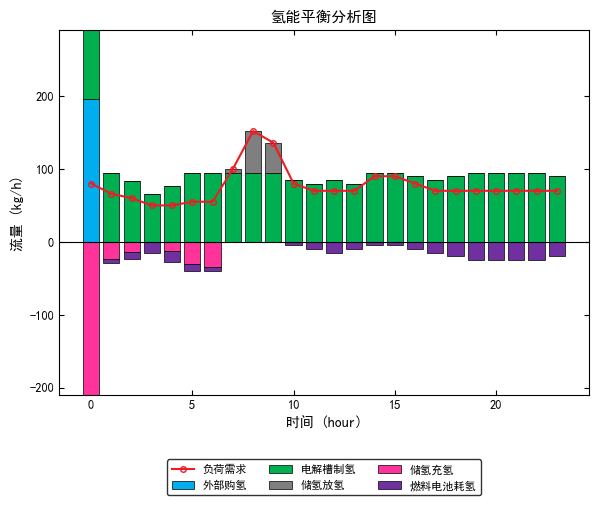

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# --- 环境设置 ---
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

# 定义学术专用色板（严格参考图2）
COLOR_MAP = {
    # 供给/购买
    "外部购电": "#00AEEF", "外部购气": "#00AEEF", "外部购氢": "#00AEEF",
    "风机出力": "#FFC000", "光伏出力": "#0A562C",
    "燃气轮机": "#ED1C24", "燃气锅炉": "#ED1C24",
    "余热锅炉": "#00B050", "电解槽制氢": "#00B050",
    "氢燃料电池": "#99CCFF", "氢燃料电池热": "#99CCFF",
    # 储能
    "蓄电池放电": "#7F7F7F", "蓄热放热": "#7F7F7F", "储气放气": "#7F7F7F", "储氢放氢": "#7F7F7F",
    "蓄电池充电": "#FF3399", "蓄热储热": "#FF3399", "储气充气": "#FF3399", "储氢充氢": "#FF3399",
    # 消耗/负荷
    "电解槽耗电": "#7030A0", "燃气轮机耗气": "#0700CD", "燃气锅炉耗气": "#7030A0", 
    "燃料电池耗氢": "#7030A0", "常规气负荷": "#404040", "氢负荷需求": "#404040"
}

def plot_balance_stack_final(t, pos_dict, neg_dict, load, title, ylabel):
    """
    终极优化版：609x521px, 刻度向内, 负荷线不被挡
    """
    x = np.array(t)
    # 精确尺寸 609x521 px
    fig, ax = plt.subplots(figsize=(6.09, 5.21), dpi=100)

    # 绘制正向柱状图 (供给侧)
    bottom_pos = np.zeros_like(x, dtype=float)
    for k, v in pos_dict.items():
        color = COLOR_MAP.get(k, "#A6A6A6") # 若无定义则默认灰色
        ax.bar(x, v, bottom=bottom_pos, label=k, color=color, 
               edgecolor='black', linewidth=0.5, zorder=2)
        bottom_pos += v

    # 绘制负向柱状图 (消耗侧)
    bottom_neg = np.zeros_like(x, dtype=float)
    for k, v in neg_dict.items():
        v_neg = -np.array(v, dtype=float)
        color = COLOR_MAP.get(k, "#D9D9D9")
        ax.bar(x, v_neg, bottom=bottom_neg, label=k, color=color, 
               edgecolor='black', linewidth=0.5, zorder=2)
        bottom_neg += v_neg

    # 核心修正：绘制负荷折线，设置 zorder=10 确保在最顶层
    ax.plot(x, load, color='#ED1C24', marker="o", markerfacecolor='none', 
            markeredgecolor='#ED1C24', markersize=4, linewidth=1.5, 
            label="负荷需求", zorder=10)

    # 细节优化
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel("时间 (hour)", fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    
    # 刻度设置：向内 + 四周封闭
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=9)
    ax.axhline(0, color='black', linewidth=0.8, zorder=3)
    
    # 图例设置：紧凑型，放在下方
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), 
              ncol=3, frameon=True, edgecolor='black', fontsize=8)

    plt.tight_layout()
    plt.show()

# ==========================================
# 调用部分：一次性生成四张图
# ==========================================

# 1. 电平衡
plot_balance_stack_final(
    res["t"], 
    {"外部购电": res["E_Buy"], "风机出力": res["WT"], "光伏出力": res["PV"], 
     "燃气轮机": res["GT_e"], "氢燃料电池": res["HFC_e"], "蓄电池放电": res["ES1_dis"]},
    {"电解槽耗电": res["EL_e"], "蓄电池充电": res["ES1_cha"]},
    res["E_Load"], "电负荷能量平衡平衡图", "功率 (MW)"
)

# 2. 热平衡
plot_balance_stack_final(
    res["t"], 
    {"余热锅炉": res["WHB_h"], "燃气锅炉": res["GB_h"], 
     "氢燃料电池热": res["HFC_h"], "蓄热放热": res["ES2_dis"]},
    {"蓄热储热": res["ES2_cha"]},
    res["H_Load"], "热负荷能量平衡平衡图", "功率 (MW)"
)

# 3. 气平衡
plot_balance_stack_final(
    res["t"],
    {"外部购气": res["G_Buy"], "储气放气": res["ES3_dis"]},
    {"储气充气": res["ES3_cha"], "燃气轮机耗气": res["GT_g"], "燃气锅炉耗气": res["GB_g"]},
    res["G_Load"],
    "天然气平衡分析图",
    "功率 (MW)"
)

# 4. 氢平衡
plot_balance_stack_final(
    res["t"],
    {"外部购氢": res["H2_Buy"], "电解槽制氢": res["EL_H2"], "储氢放氢": res["ES4_dis"]},
    {"储氢充氢": res["ES4_cha"], "燃料电池耗氢": res["HFC_H2"]},
    res["H2_Load"],
    "氢能平衡分析图",
    "流量 (kg/h)"
)

风电弃电惩罚 = 0
风电弃电惩罚 = 20
风电弃电惩罚 = 40
风电弃电惩罚 = 60
风电弃电惩罚 = 80
风电弃电惩罚 = 100
风电弃电惩罚 = 120
风电弃电惩罚 = 140
风电弃电惩罚 = 160
风电弃电惩罚 = 180
风电弃电惩罚 = 200
光伏弃电惩罚 = 0
光伏弃电惩罚 = 20
光伏弃电惩罚 = 40
光伏弃电惩罚 = 60
光伏弃电惩罚 = 80
光伏弃电惩罚 = 100
光伏弃电惩罚 = 120
光伏弃电惩罚 = 140
光伏弃电惩罚 = 160
光伏弃电惩罚 = 180
光伏弃电惩罚 = 200


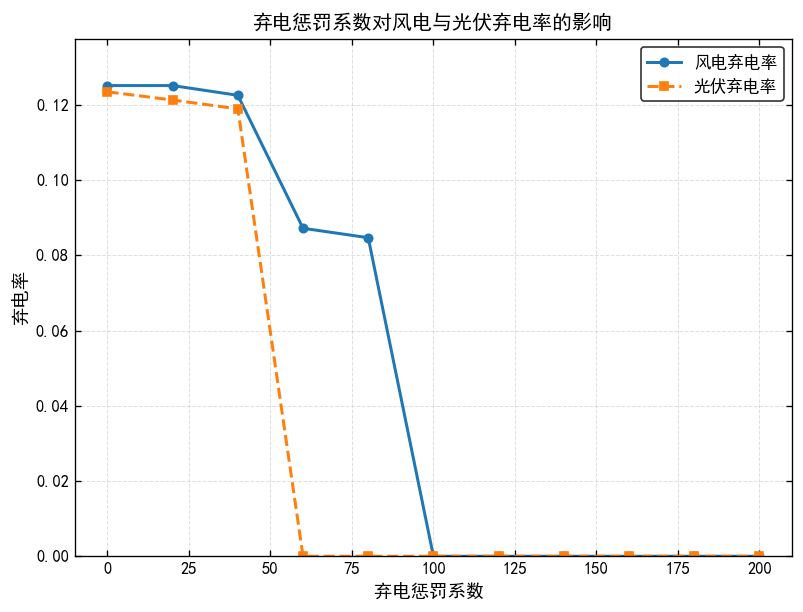

In [ ]:
def set_objective_with_penalty(model, wind_penalty, solar_penalty):
    total_cost = grb.LinExpr()

    for t in range(T):
        # 外购
        total_cost += electricity_price[t] * Pbuy_e[t] * dt
        total_cost += natural_gas_price * Pbuy_g[t] * dt
        total_cost += hydrogen_price * (Pbuy_H[t] * meh) * dt

        # 设备运维
        total_cost += αGT * PGT_e[t] * dt
        total_cost += αGB * PGB_h[t] * dt
        total_cost += αWHB * PWHB_h[t] * dt
        total_cost += αEL * PEL_e[t] * dt
        total_cost += αHFC * PHFC_tot[t] * dt
        total_cost += αWT * PWT[t] * dt
        total_cost += αPV * PPV[t] * dt

        # 储能
        total_cost += α1 * (Pcha1[t] + Pdis1[t]) * dt
        total_cost += α2 * (Pcha2[t] + Pdis2[t]) * dt
        total_cost += α3 * (Pcha3[t] + Pdis3[t]) * dt
        total_cost += α4 * (Pcha4[t] + Pdis4[t]) * dt

        # 弃电惩罚（⚠️唯一会被扫描的部分）
        total_cost += wind_penalty  * PWT_cut[t] * dt
        total_cost += solar_penalty * PPV_cut[t] * dt

    model.setObjective(total_cost, GRB.MINIMIZE)
wind_penalty_list = list(range(0, 201, 20))
WT_curt_rate = []

WT_av = np.array(WT_avail, dtype=float)
WT_av_total = WT_av.sum()

solar_penalty_fixed = 200.0   # 固定光伏弃电惩罚

for wp in wind_penalty_list:
    print(f"风电弃电惩罚 = {wp}")

    set_objective_with_penalty(model, wp, solar_penalty_fixed)
    model.optimize()

    if model.status != GRB.OPTIMAL:
        WT_curt_rate.append(np.nan)
        continue

    WT_cut = np.array([PWT_cut[t].X for t in range(T)])
    rate = WT_cut.sum() / WT_av_total if WT_av_total > 1e-9 else np.nan
    WT_curt_rate.append(rate)

solar_penalty_list = list(range(0, 201, 20))
PV_curt_rate = []

PV_av = np.array(PV_avail, dtype=float)
PV_av_total = PV_av.sum()

wind_penalty_fixed = 200.0   # 固定风电弃电惩罚

for sp in solar_penalty_list:
    print(f"光伏弃电惩罚 = {sp}")

    set_objective_with_penalty(model, wind_penalty_fixed, sp)
    model.optimize()

    if model.status != GRB.OPTIMAL:
        PV_curt_rate.append(np.nan)
        continue

    PV_cut = np.array([PPV_cut[t].X for t in range(T)])
    rate = PV_cut.sum() / PV_av_total if PV_av_total > 1e-9 else np.nan
    PV_curt_rate.append(rate)


fig, ax = plt.subplots(figsize=(6.8, 5.2), dpi=120)

# 风电曲线
ax.plot(
    wind_penalty_list, WT_curt_rate,
    marker='o', linestyle='-',
    linewidth=1.8, markersize=5,
    label="风电弃电率"
)

# 光伏曲线
ax.plot(
    solar_penalty_list, PV_curt_rate,
    marker='s', linestyle='--',
    linewidth=1.8, markersize=5,
    label="光伏弃电率"
)

# 坐标轴与标题
ax.set_xlabel("弃电惩罚系数 ", fontsize=11)
ax.set_ylabel("弃电率", fontsize=11)
ax.set_title("弃电惩罚系数对风电与光伏弃电率的影响", fontsize=12, fontweight='bold')

# 刻度向内 + 四周封闭
ax.tick_params(
    axis='both', which='both',
    direction='in',
    top=True, right=True,
    labelsize=10
)

# 网格（淡化）
ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.4)

# y 轴范围（保证可读性）
ax.set_ylim(
    0,
    max(
        np.nanmax(WT_curt_rate),
        np.nanmax(PV_curt_rate)
    ) * 1.1
)

# 图例
ax.legend(
    loc="upper right",
    frameon=True,
    edgecolor="black",
    fontsize=10
)

plt.tight_layout()
plt.show()